In [1]:
from tqdm import tqdm

import os
from dotenv import load_dotenv

load_dotenv()
tqdm.pandas()
import pandas as pd
import ast
import re
import torch
import torch.nn.functional as F
from dataset_utils import *

# Loading Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", "raw")
dataset.set_format(type="pandas")
df_train = dataset["train"][:]

emotions = list(df_train.columns)[9:]
columns = ["text"] + emotions
# select only texts and emotions
df_train = df_train[columns]


# create new column with list of emotions (in strings)
df_train["ds_emotions"] = df_train[emotions].progress_apply(
    lambda x: x.index[x == 1].tolist(), axis=1
)

100%|██████████| 211225/211225 [00:13<00:00, 15532.11it/s]


In [3]:
# get samples with neutral emotion (20 samples)
import sys

sys.path.append("..")
from config import RANDOM_SEED

# samples = df_train[df_train["ds_emotions"].apply(lambda x: "neutral" in x)]
samples = df_train.sample(100, random_state=RANDOM_SEED)
# drop emotions columns
samples = samples.drop(emotions, axis=1)

In [4]:
# read the first 60 samples of gpt labeled data
gpt_labeled = pd.read_csv("gpt_labeled.csv")
gpt_labeled = gpt_labeled.head(60)

# drop human_intervension column
gpt_labeled = gpt_labeled.drop("human_intervention", axis=1)

# get the first 60 samples of samples
samples = samples.head(60)

# LLM Labeling

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

SYSTEM_MESSAGE = "You're an AI expert trained to analyze and categorize emotions present in text. Your goal is to analyze each piece of text according to instructions"

PROMPT_TEMPLATE = f"""
Given: {{comment}}
Emotion list: {emotions}
Perform an emotional analysis of the comment to by following these steps:

Literal analysis: Identify emotions directly expressed through obvious emotional words/phrases.
Contextual analysis: Consider the full context and implications to detect any additional underlying emotions.
Tonal analysis: Examine tone, subtext, and nuanced emotional cues beyond the literal language.

You may only pick one, two or three classes.

For each level of analysis, provide your findings.
Then, summarize by listing the emotion class(es) that apply in <answer> (classes) </answer>. Use "neutral" ONLY if no emotions from the list are detected.
"""


final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [6]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [7]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.6

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

chain = final_prompt | chat

In [8]:
samples["predictions"] = None
input_tokens = 0
output_tokens = 0
# for index in range(len(samples)):
for index in tqdm(samples.index):
    comment = samples.loc[index]["text"]
    label = samples.loc[index]["ds_emotions"]
    response = chain.invoke({"comment": comment})
    content = response.content
    input_tokens += response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens += response.response_metadata["token_usage"]["completion_tokens"]
    extracted_emotions = extract_emotions(content)
    samples.at[index, "predictions"] = extracted_emotions

input_tokens = input_tokens / len(samples)
output_tokens = output_tokens / len(samples)

100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


# Evaluation

Results for llama-v3-70b-instruct:
Average BCE Loss: 3.3056
Average F1 Score: 0.4197
Average Precision: 0.4168
Average Recall: 0.5006
Average Accuracy: 0.9292


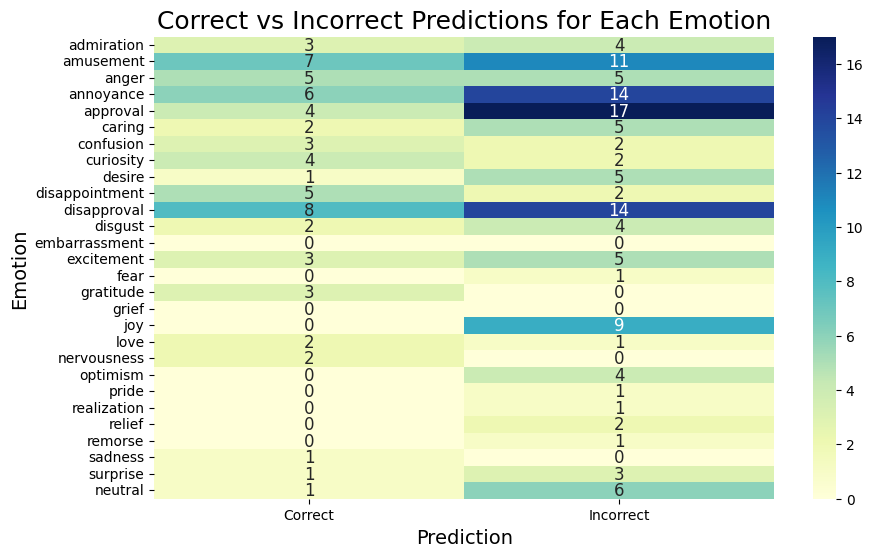

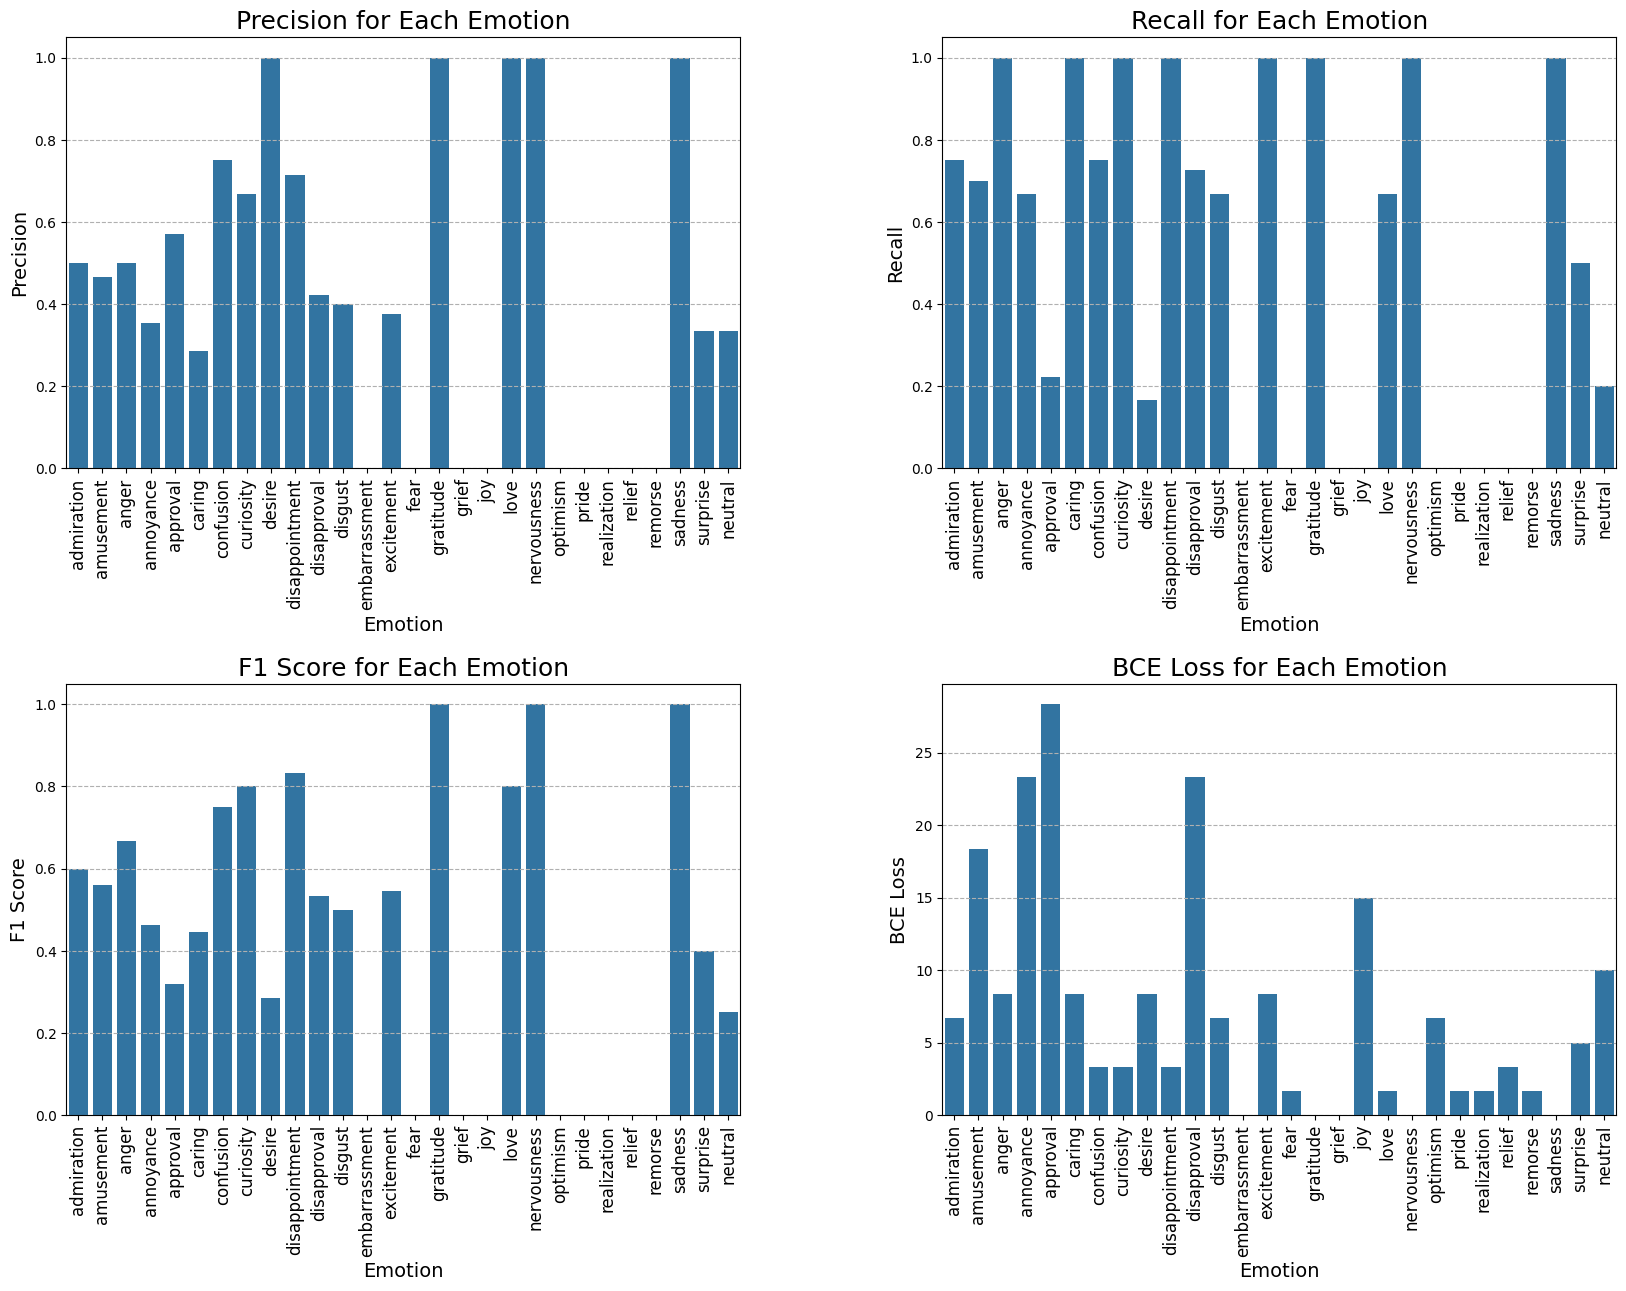

In [9]:
predicted_labels = samples["predictions"]

kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": input_tokens,
    "avg_output_tokens": output_tokens,
    # Additional Kwargs
    "ensemble": 1,
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    gpt_labeled["ground_truth"],
    emotions,
    verbose=True,
    **kwargs,
)